In [17]:
import cv2
import mediapipe as mp
import numpy as np
import time, os

actions = ['best','ok','yeah','heart']
# seq_length - 동작으로 인식하는 길이 / secs_for_action - 촬영시간
seq_length = 30
secs_for_action = 60

# MediaPipe hands model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

pose =  mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5)

cap = cv2.VideoCapture(0)

#촬영시간 기록 + dataset폴더 만들기
created_time = int(time.time())
os.makedirs('dataset', exist_ok=True)

#촬영 시작
while cap.isOpened():
    for idx, action in enumerate(actions):
        data = []

        ret, img = cap.read()
        img = cv2.flip(img, 1)

        #영상 촬영 대기안내 및 대기시간 설정
        cv2.putText(img, f'Waiting for collecting {action.upper()} action...', org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
        cv2.imshow('img', img)
        cv2.waitKey(3000)

        start_time = time.time()
        #시간 설정 시간만큼 기록
        while time.time() - start_time < secs_for_action:
            ret, img = cap.read()

            img = cv2.flip(img, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = hands.process(img)
            results = pose.process(img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            
            if result.multi_hand_landmarks is not None and results.pose_landmarks is not None:
                for res in result.multi_hand_landmarks:
                    joint = np.zeros((21, 4))
                    for j, lm in enumerate(res.landmark):
                        joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

                    # Compute angles between joints
                    v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
                    v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
                    v = v2 - v1 # [20, 3]
                    # Normalize v
                    v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                    # Get angle using arcos of dot product
                    angle = np.arccos(np.einsum('nt,nt->n',
                        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

                    #각도 기록
                    angle = np.degrees(angle) # Convert radian to degree
                    # dist = np.linalg.norm(np.array([results.pose_landmarks.landmark[7].x,results.pose_landmarks.landmark[7].y,results.pose_landmarks.landmark[7].z]) - np.array([results.pose_landmarks.landmark[15].x,results.pose_landmarks.landmark[15].y,results.pose_landmarks.landmark[15].z]))
                    # angle = np.append(angle,dist)

                    # 각도 기록 및 라벨링
                    angle_label = np.array([angle], dtype=np.float32)
                    angle_label = np.append(angle_label, idx)
                    
                    d = np.concatenate([joint.flatten(), angle_label])
                    #데이터에 기록하기
                    data.append(d)
                    
                    mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)
                    mp_drawing.draw_landmarks(img,results.pose_landmarks,mp_pose.POSE_CONNECTIONS,landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

            cv2.imshow('img', img)
            #q 누르면 종료 / 다음기록으로 넘어감
            if cv2.waitKey(1) == ord('q'):
                break

        data = np.array(data)
        print(action, data.shape)
        np.save(os.path.join('dataset', f'raw_{action}_{created_time}'), data)

        # Create sequence data
        full_seq_data = []
        for seq in range(len(data) - seq_length):
            full_seq_data.append(data[seq:seq + seq_length])

        full_seq_data = np.array(full_seq_data)
        print(action, full_seq_data.shape)
        np.save(os.path.join('dataset', f'seq_{action}_{created_time}'), full_seq_data)
    break
cv2.destroyAllWindows()

best (535, 100)
best (505, 30, 100)
ok (551, 100)
ok (521, 30, 100)
yeah (546, 100)
yeah (516, 30, 100)
heart (544, 100)
heart (514, 30, 100)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                41984     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                                 
Total params: 44,196
Trainable params: 44,196
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
54/58 [==========================>...] - ETA: 0s - loss: 24.5915 - acc: 0.3038
Epoch 1: val_acc improved from -inf to 0.30097, saving model to static\model.h5
58/58 [==============================] - 1s 8ms/step - loss: 25.3244 - acc: 0.3054 - val_loss: 42.4533 - val_acc: 0.3010 - lr: 0.0010
Epoch 2/2

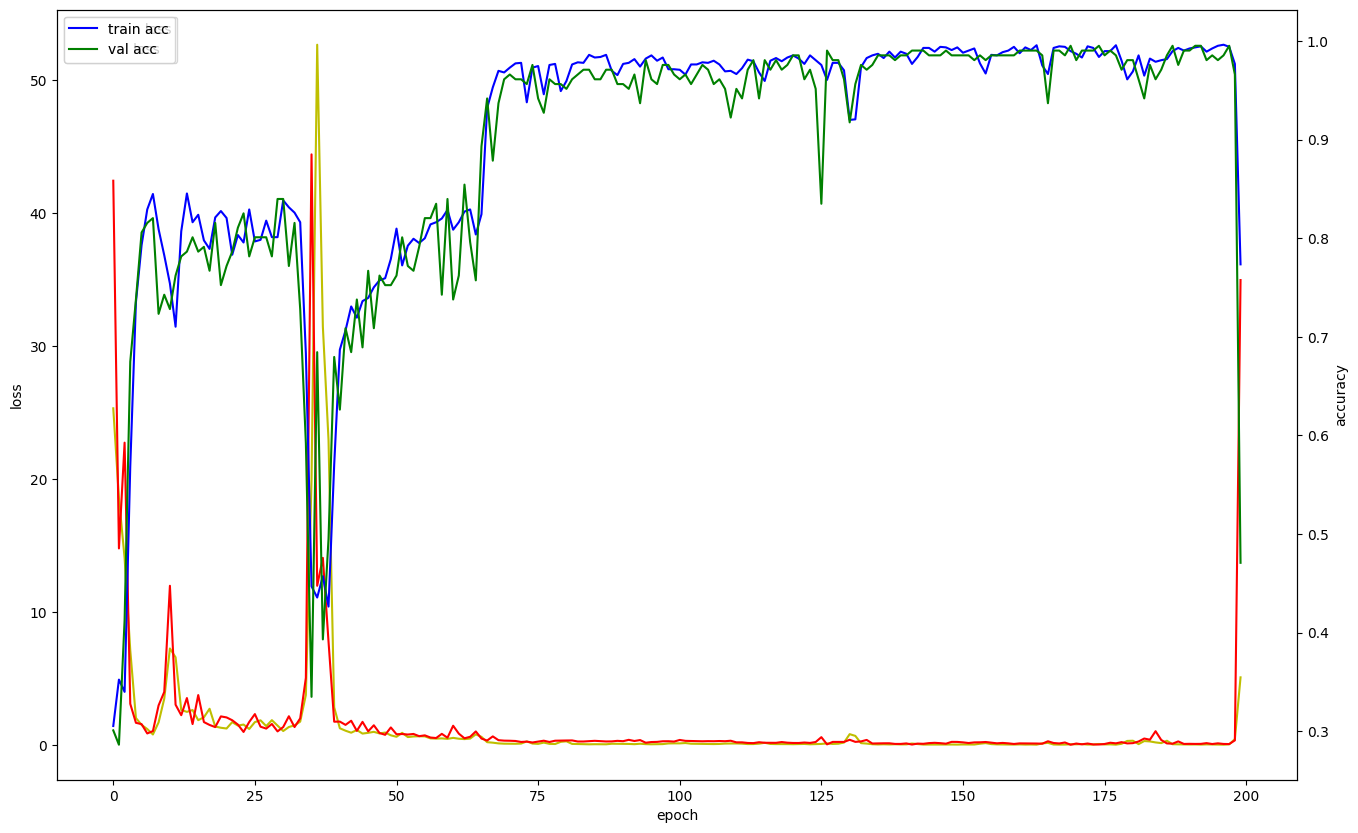

7/7 [==============================] - 0s 2ms/step


array([[[153,   0],
        [  0,  53]],

       [[164,   0],
        [  0,  42]],

       [[156,   0],
        [  1,  49]],

       [[144,   1],
        [  0,  61]]], dtype=int64)

In [18]:
#딥러닝 학습파트

import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

#CUDA_VISIBLE_DEVICES : GPU 사용 지정  : 0번,1번,2번,...
#'TF_FORCE_GPU_ALLOW_GROWTH : GPU 메모리 사용 제한 -제한 안걸면 메모리 다 끌어다 씀
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#액션 목록
actions = ['best','ok','yeah','heart']

#dataset 내 seq 붙은 data만 가져옮
seq_data = ['dataset/'+i for i in os.listdir('dataset') if 'seq' in i]

data = np.concatenate(list(map(np.load,seq_data)))

#학습 데이터와 레이블로 분리
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

#딥러닝 LSTM 모델 사용
y_data = to_categorical(labels, num_classes=len(actions))

#자료를 학습용/평가용으로 분리
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

#딥러닝 모델 구축 - sequntial - LSTM,Dense 알고리즘 사용
model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()


history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('static/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

#딥러닝 손실함수 및 정답률 그래프그리기
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

model = load_model('static/model.h5')

y_pred = model.predict(x_val)

#혼동행렬
multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))


In [40]:
#딥러닝 적용 모델 이용한 모션 구별

#library import
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
from multiprocessing import Process ,Queue
import time
#액션 구분 및 행동 길이 설정
actions =  ['best','ok','yeah','heart']
seq_length = 30

#학습모델 로드
model = load_model('static/model.h5')

# MediaPipe hands model
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose

hands = mp_hands.Hands(
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

def overlay(img, x, y, w, h, overlay_image): # 대상 이미지 (3채널), x, y 좌표, width, height, 덮어씌울 이미지 (4채널:투명도를 가짐)
    alpha = overlay_image[:, :, 3]   # BGR
    image_alpha = alpha/ 255  # 0 ~ 255 -> 255 로 나누면 0 ~ 1 사이의 값 (1: 불투명, 0: 완전투명)
    for c in range(3): # channel BGR
        img[y-h:y+h, x-w:x+w, c] = (overlay_image[:, :, c] * image_alpha) + (img[y-h:y+h, x-w:x+w, c] * (1 - image_alpha))

cap = cv2.VideoCapture(0)

#캠 너비 및 높이 로드
width_cam = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height_cam = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

img_size = 40

#sequence 및 action 저장할 리스트 생성
seq = []
action_seq = []

#캐릭터 이미지 로드
img_good = cv2.resize(cv2.imread('static/icon/good-job.png',-1),(80,80))
img_ok = cv2.resize(cv2.imread('static/icon/ok.png',-1),(80,80))
img_lovely = cv2.resize(cv2.imread('static/icon/lovely.png',-1),(80,80))
img_heart = cv2.resize(cv2.imread('static/icon/heart.png',-1),(80,80))

# 시간 및 카운터 설정
start_time = time.time()
text_counter = 0

while cap.isOpened():
    ret, img = cap.read()
    img0 = img.copy()

    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if time.time() - start_time > 2:
        start_time = time.time()
    
    cv2.putText(img, f'best, ok, yeah, heart'.upper(), org=(120,50),  fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
    if result.multi_hand_landmarks is not None:
        for res in result.multi_hand_landmarks:
            finger = res.landmark[8]
            h, w, _=img.shape 
            x_finger, y_finger=int(finger.x*w), int(finger.y*h)
            joint = np.zeros((21, 4))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

            # Compute angles between joints
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
            v = v2 - v1 # [20, 3]
            # Normalize v
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]
            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle) # Convert radian to degree
            # angle = np.append(angle,dist)
            d = np.concatenate([joint.flatten(), angle])

            seq.append(d)

            if len(seq) < seq_length:
                continue
            
            input_data = np.expand_dims(np.array(seq[-seq_length:], dtype=np.float32), axis=0)
            
            y_pred = model.predict(input_data).squeeze()
            #학습모델 불러 맞는지 확인
            i_pred = int(np.argmax(y_pred))
            conf = y_pred[i_pred]
            #확률 90% 이상 일 때 action값 보여줌
            if conf < 0.9:
                continue
            action = actions[i_pred]
            action_seq.append(action)
            #행동값이 적으면 일단 실행
            if len(action_seq) < 3:
                continue
            #행동을 프레임으로 구분 - 마지막, 그 전, 그 전전이 같은 행동이면 교체
            this_action = '?'
            if action_seq[-1] == action_seq[-2] == action_seq[-3]:
                this_action = action
                #현재 행동이 무엇인가에 따라 실행 
                if this_action == actions[0]:        
                    overlay(img, x_finger+100, y_finger-50, img_size, img_size, img_good)
    
                elif this_action == actions[1]:
                    overlay(img, x_finger+150, y_finger, img_size, img_size, img_ok)
                    
                elif this_action == actions[2]:
                    overlay(img, x_finger, y_finger-50, img_size, img_size, img_lovely)

                elif this_action == actions[3]:
                    overlay(img, x_finger, y_finger-50, img_size, img_size, img_heart)
                             
            cv2.putText(img, f'{this_action.upper()}', org=(220, 450), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
            # 시간이 2초 이상이면 화면 캡쳐
            if time.time() - start_time >= 2 :
                cv2.imwrite(f'./image/capture_{time.time()}.png',img)
                # 캡쳐 후 counter 추가
                text_counter += 1
            # counter가 1보다 크면 실행
            for i in range(text_counter):
                cv2.putText(img, 'captured', org=(30,100), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(225, 0, 225), thickness=2)
                if text_counter >= 2:
                    text_counter = 0

    cv2.putText(img, f'Action: ', org=(100, 450), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

    cv2.imshow('img', img)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 13ms/step


In [ ]:
time.time() - text_time

https://github.com/kairess/gesture-recognition/blob/1bb383e00af23f9dcdfa8892900047e5cef964fc/create_dataset.py#L7